In [1]:
!pip install --upgrade -q transformers datasets

In [2]:
!pip install --upgrade -q pyarrow

In [3]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
!pip install --upgrade -q transformers[torch]

In [5]:
import numpy as np 
import pandas as pd 
import os

for dirname, _, filenames in os.walk('contradictory-my-dear-watson'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

contradictory-my-dear-watson\sample_submission.csv
contradictory-my-dear-watson\test.csv
contradictory-my-dear-watson\train.csv


In [6]:
# Load data
from datasets import load_dataset, DatasetDict


data = load_dataset('csv', data_files='contradictory-my-dear-watson/train.csv', split='train')
data = data.train_test_split(0.2)

data = DatasetDict({
    'train': data['train'],
    'val': data['test'],
    'test':load_dataset('csv', data_files='contradictory-my-dear-watson/test.csv', split='train')
})

data

c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 9696
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [7]:
df = data['train'].to_pandas()
df

,id,premise,hypothesis,lang_abv,language,label
0,821ec82d21,"With an area of just 541 sq km (209 sq miles),...",It is an island in the Mediterranean Sea.,en,English,1
1,fb939d82cd,"Vào tháng Năm hoặc tháng Sáu, Clarke đã yêu cầ...",Clarke muốn chuyển sang lĩnh vực an ninh mạng ...,vi,Vietnamese,1
2,dcd780c2f2,مجھے کورس میں تربیت شروع کرنا پڑا.,مجھے تیاری کی کوئی ضرورت نہیں تھی.,ur,Urdu,2
3,642b888dc0,RH-II etiqueta esta expresión actual como prov...,"Según RH-II, esta expresión significa estar al...",es,Spanish,0
4,381e2fb038,"the approving official's knowledge true, corre...",The approving official knowledge is in accorda...,en,English,0
...,...,...,...,...,...,...
9691,40ae029767,"I had rejected it as absurd, nevertheless it p...",It persisted even after I rejected it as an ab...,en,English,0
9692,33368cc505,"In fact, the Lions of Delos were made from Nax...","There are five Lions of Delos, and also two Ti...",en,English,1
9693,60522de44a,"CIA đã dỡ bỏ tấm phim, đưa chúng đến Liên Hiệp...",CIA cho rằng Liên hiệp quốc cần xem phim ngay ...,vi,Vietnamese,1
9694,c803e3b7ed,"Comme pour tous les dons à l'Institut, 100% de...",Nous dépensons la moitié de votre argent en fr...,fr,French,2


In [8]:
df[['premise', 'hypothesis', 'lang_abv', 'language']].describe()

,premise,hypothesis,lang_abv,language
count,9696,9696,9696,9696
unique,7056,9696,15,15
top,It is constrained by laws and regulations form...,It is an island in the Mediterranean Sea.,en,English
freq,3,1,5491,5491


In [9]:
df[['lang_abv', 'language']].value_counts()

lang_abv  language  
en        English       5491
zh        Chinese        331
ar        Arabic         321
ur        Urdu           314
fr        French         311
sw        Swahili        308
vi        Vietnamese     301
es        Spanish        299
ru        Russian        298
th        Thai           297
el        Greek          294
hi        Hindi          290
de        German         288
bg        Bulgarian      284
tr        Turkish        269
Name: count, dtype: int64

In [10]:
df.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

checkpoint = 'symanto/xlm-roberta-base-snli-mnli-anli-xnli'
# checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [12]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 9696
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [13]:
def preprocess_data(batch):
    batch['text'] = [x1 + f' {tokenizer.sep_token} ' + x2 for x1, x2 in zip(batch['premise'],batch['hypothesis'])]
    return tokenizer(batch['text'])

data = data.map(preprocess_data, batched=True)
data

Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map: 100%|██████████| 2424/2424 [00:00<00:00, 11924.29 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 9696
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'text', 'input_ids', 'attention_mask'],
        num_rows: 5195
    })
})

In [14]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import load_metric


def compute_metrics(eval_pred):
    metric = load_metric('accuracy')
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)


train_args = TrainingArguments(
    output_dir='results',
    logging_dir='logs',
    # report_to=[],
    
    evaluation_strategy='steps',
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=5,
    fp16=True,
    
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    # save_total_limit=3,
    save_only_model = True
)

train_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=200,
evaluation_strategy=IntervalStrategy.STEPS,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fs

In [15]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data['train'],
    eval_dataset=data['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(3)]
)

trainer.train()

c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  7%|▋         | 200/3030 [00:50<10:25,  4.52it/s] 

{'loss': 0.3274, 'grad_norm': 13.023253440856934, 'learning_rate': 1.8712871287128715e-05, 'epoch': 0.33}


C:\Users\andyp\AppData\Local\Temp\ipykernel_31556\3824274857.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')
c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                  
  7%|▋         | 200/3030 [00:55<10:25,  4.52it/s]

{'eval_loss': 0.30189400911331177, 'eval_accuracy': 0.8873762376237624, 'eval_runtime': 5.0882, 'eval_samples_per_second': 476.394, 'eval_steps_per_second': 29.873, 'epoch': 0.33}


 13%|█▎        | 400/3030 [01:44<09:52,  4.44it/s]  

{'loss': 0.3592, 'grad_norm': 29.558683395385742, 'learning_rate': 1.7392739273927396e-05, 'epoch': 0.66}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                  
 13%|█▎        | 400/3030 [01:49<09:52,  4.44it/s]

{'eval_loss': 0.283189982175827, 'eval_accuracy': 0.8923267326732673, 'eval_runtime': 4.8818, 'eval_samples_per_second': 496.538, 'eval_steps_per_second': 31.136, 'epoch': 0.66}


 20%|█▉        | 600/3030 [02:37<09:14,  4.38it/s]  

{'loss': 0.368, 'grad_norm': 6.029458999633789, 'learning_rate': 1.607920792079208e-05, 'epoch': 0.99}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                  
 20%|█▉        | 600/3030 [02:42<09:14,  4.38it/s]

{'eval_loss': 0.2855377495288849, 'eval_accuracy': 0.8915016501650165, 'eval_runtime': 4.6061, 'eval_samples_per_second': 526.261, 'eval_steps_per_second': 33.0, 'epoch': 0.99}


 26%|██▋       | 800/3030 [03:30<08:29,  4.38it/s]  

{'loss': 0.2377, 'grad_norm': 78.90982818603516, 'learning_rate': 1.475907590759076e-05, 'epoch': 1.32}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                  
 26%|██▋       | 800/3030 [03:35<08:29,  4.38it/s]

{'eval_loss': 0.3242925703525543, 'eval_accuracy': 0.8894389438943895, 'eval_runtime': 4.7774, 'eval_samples_per_second': 507.393, 'eval_steps_per_second': 31.817, 'epoch': 1.32}


 33%|███▎      | 1000/3030 [04:23<08:10,  4.14it/s] 

{'loss': 0.2261, 'grad_norm': 40.18636703491211, 'learning_rate': 1.343894389438944e-05, 'epoch': 1.65}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 33%|███▎      | 1000/3030 [04:28<08:10,  4.14it/s]

{'eval_loss': 0.36010369658470154, 'eval_accuracy': 0.8865511551155115, 'eval_runtime': 4.7431, 'eval_samples_per_second': 511.063, 'eval_steps_per_second': 32.047, 'epoch': 1.65}


 40%|███▉      | 1200/3030 [05:19<07:08,  4.28it/s]  

{'loss': 0.212, 'grad_norm': 10.223922729492188, 'learning_rate': 1.211881188118812e-05, 'epoch': 1.98}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 40%|███▉      | 1200/3030 [05:24<07:08,  4.28it/s]

{'eval_loss': 0.3660227060317993, 'eval_accuracy': 0.8894389438943895, 'eval_runtime': 4.7039, 'eval_samples_per_second': 515.317, 'eval_steps_per_second': 32.314, 'epoch': 1.98}


 46%|████▌     | 1400/3030 [06:13<06:11,  4.38it/s]  

{'loss': 0.1628, 'grad_norm': 111.69198608398438, 'learning_rate': 1.0798679867986799e-05, 'epoch': 2.31}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 46%|████▌     | 1400/3030 [06:17<06:11,  4.38it/s]

{'eval_loss': 0.5592401623725891, 'eval_accuracy': 0.8927392739273927, 'eval_runtime': 4.6813, 'eval_samples_per_second': 517.803, 'eval_steps_per_second': 32.47, 'epoch': 2.31}


 53%|█████▎    | 1600/3030 [07:08<05:28,  4.36it/s]

{'loss': 0.1534, 'grad_norm': 0.5136643052101135, 'learning_rate': 9.47854785478548e-06, 'epoch': 2.64}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 53%|█████▎    | 1600/3030 [07:13<05:28,  4.36it/s]

{'eval_loss': 0.5975005626678467, 'eval_accuracy': 0.8898514851485149, 'eval_runtime': 4.7797, 'eval_samples_per_second': 507.145, 'eval_steps_per_second': 31.801, 'epoch': 2.64}


 59%|█████▉    | 1800/3030 [08:02<04:41,  4.37it/s]

{'loss': 0.1576, 'grad_norm': 191.8006591796875, 'learning_rate': 8.158415841584158e-06, 'epoch': 2.97}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 59%|█████▉    | 1800/3030 [08:07<04:41,  4.37it/s]

{'eval_loss': 0.5510759353637695, 'eval_accuracy': 0.889026402640264, 'eval_runtime': 4.8397, 'eval_samples_per_second': 500.86, 'eval_steps_per_second': 31.407, 'epoch': 2.97}


 66%|██████▌   | 2000/3030 [09:02<07:57,  2.16it/s]

{'loss': 0.1039, 'grad_norm': 49.36105728149414, 'learning_rate': 6.838283828382839e-06, 'epoch': 3.3}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 66%|██████▌   | 2000/3030 [09:09<07:57,  2.16it/s]

{'eval_loss': 0.6712801456451416, 'eval_accuracy': 0.893976897689769, 'eval_runtime': 7.2665, 'eval_samples_per_second': 333.587, 'eval_steps_per_second': 20.918, 'epoch': 3.3}


 73%|███████▎  | 2200/3030 [10:01<03:32,  3.91it/s]

{'loss': 0.0864, 'grad_norm': 0.14867907762527466, 'learning_rate': 5.5181518151815185e-06, 'epoch': 3.63}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 73%|███████▎  | 2200/3030 [10:08<03:32,  3.91it/s]

{'eval_loss': 0.673556387424469, 'eval_accuracy': 0.8935643564356436, 'eval_runtime': 7.2054, 'eval_samples_per_second': 336.415, 'eval_steps_per_second': 21.095, 'epoch': 3.63}


 79%|███████▉  | 2400/3030 [10:57<02:27,  4.29it/s]

{'loss': 0.0895, 'grad_norm': 114.59953308105469, 'learning_rate': 4.198019801980198e-06, 'epoch': 3.96}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 79%|███████▉  | 2400/3030 [11:02<02:27,  4.29it/s]

{'eval_loss': 0.6718523502349854, 'eval_accuracy': 0.8898514851485149, 'eval_runtime': 5.0576, 'eval_samples_per_second': 479.275, 'eval_steps_per_second': 30.054, 'epoch': 3.96}


 86%|████████▌ | 2600/3030 [11:51<01:43,  4.15it/s]

{'loss': 0.0578, 'grad_norm': 3.829220771789551, 'learning_rate': 2.877887788778878e-06, 'epoch': 4.29}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 86%|████████▌ | 2600/3030 [11:56<01:43,  4.15it/s]

{'eval_loss': 0.6998197436332703, 'eval_accuracy': 0.8923267326732673, 'eval_runtime': 4.8712, 'eval_samples_per_second': 497.619, 'eval_steps_per_second': 31.204, 'epoch': 4.29}


 92%|█████████▏| 2800/3030 [12:46<00:56,  4.04it/s]

{'loss': 0.0418, 'grad_norm': 0.03746107593178749, 'learning_rate': 1.557755775577558e-06, 'epoch': 4.62}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 92%|█████████▏| 2800/3030 [12:51<00:56,  4.04it/s]

{'eval_loss': 0.7430553436279297, 'eval_accuracy': 0.893976897689769, 'eval_runtime': 5.1528, 'eval_samples_per_second': 470.427, 'eval_steps_per_second': 29.499, 'epoch': 4.62}


 99%|█████████▉| 3000/3030 [13:40<00:07,  4.15it/s]

{'loss': 0.0345, 'grad_norm': 0.02360260859131813, 'learning_rate': 2.3762376237623766e-07, 'epoch': 4.95}


c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
                                                   
 99%|█████████▉| 3000/3030 [13:45<00:07,  4.15it/s]

{'eval_loss': 0.7571778893470764, 'eval_accuracy': 0.8927392739273927, 'eval_runtime': 5.1616, 'eval_samples_per_second': 469.618, 'eval_steps_per_second': 29.448, 'epoch': 4.95}


100%|██████████| 3030/3030 [13:56<00:00,  3.62it/s]

{'train_runtime': 836.1554, 'train_samples_per_second': 57.98, 'train_steps_per_second': 3.624, 'train_loss': 0.1733822006203554, 'epoch': 5.0}


TrainOutput(global_step=3030, training_loss=0.1733822006203554, metrics={'train_runtime': 836.1554, 'train_samples_per_second': 57.98, 'train_steps_per_second': 3.624, 'train_loss': 0.1733822006203554, 'epoch': 5.0})

In [17]:
log = trainer.state.log_history
log

[{'loss': 0.3274,
  'grad_norm': 13.023253440856934,
  'learning_rate': 1.8712871287128715e-05,
  'epoch': 0.33,
  'step': 200},
 {'eval_loss': 0.30189400911331177,
  'eval_accuracy': 0.8873762376237624,
  'eval_runtime': 5.0882,
  'eval_samples_per_second': 476.394,
  'eval_steps_per_second': 29.873,
  'epoch': 0.33,
  'step': 200},
 {'loss': 0.3592,
  'grad_norm': 29.558683395385742,
  'learning_rate': 1.7392739273927396e-05,
  'epoch': 0.66,
  'step': 400},
 {'eval_loss': 0.283189982175827,
  'eval_accuracy': 0.8923267326732673,
  'eval_runtime': 4.8818,
  'eval_samples_per_second': 496.538,
  'eval_steps_per_second': 31.136,
  'epoch': 0.66,
  'step': 400},
 {'loss': 0.368,
  'grad_norm': 6.029458999633789,
  'learning_rate': 1.607920792079208e-05,
  'epoch': 0.99,
  'step': 600},
 {'eval_loss': 0.2855377495288849,
  'eval_accuracy': 0.8915016501650165,
  'eval_runtime': 4.6061,
  'eval_samples_per_second': 526.261,
  'eval_steps_per_second': 33.0,
  'epoch': 0.99,
  'step': 600},


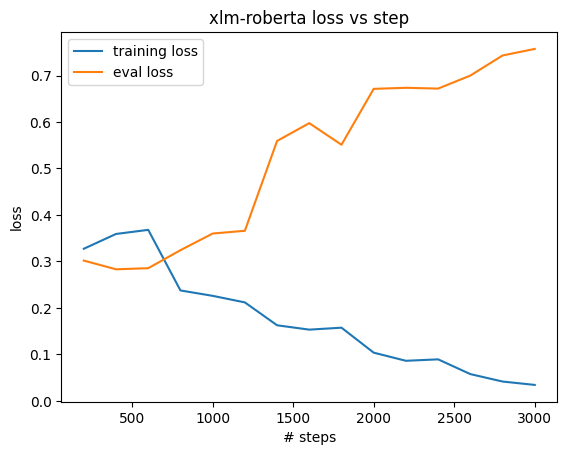

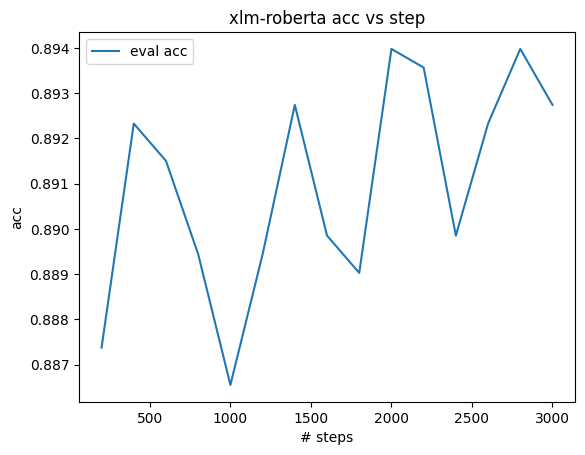

In [18]:
steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log['step'])
    train_loss.append(train_log['loss'])
    eval_loss.append(eval_log['eval_loss'])
    eval_acc.append(eval_log['eval_accuracy'])

import matplotlib.pyplot as plt

plt.title('xlm-roberta loss vs step')
plt.xlabel('# steps')
plt.ylabel('loss')
plt.plot(steps, train_loss, label='training loss')
plt.plot(steps, eval_loss, label='eval loss')
plt.legend()
plt.show()

plt.title('xlm-roberta acc vs step')
plt.xlabel('# steps')
plt.ylabel('acc')
plt.plot(steps, eval_acc, label='eval acc')
plt.legend()
plt.show()

In [16]:
preds = trainer.predict(data['test'])
preds

100%|██████████| 325/325 [00:06<00:00, 53.13it/s]


PredictionOutput(predictions=array([[-3.0859375, -2.9960938,  6.0820312],
       [-2.2226562,  3.7324219, -2.234375 ],
       [ 5.8867188, -1.9052734, -2.4628906],
       ...,
       [ 5.5390625, -1.921875 , -2.1699219],
       [ 4.03125  , -1.2001953, -1.7792969],
       [-3.3984375, -2.5039062,  5.8789062]], dtype=float32), label_ids=None, metrics={'test_runtime': 6.3625, 'test_samples_per_second': 816.498, 'test_steps_per_second': 51.08})

In [17]:
pd.DataFrame({
    'id': data['test']['id'],
    'prediction': np.argmax(preds.predictions, axis=1)
}).to_csv('submission.csv', header=True, index=False)